# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

# Для проверяющего

Здравствуйте, сразу хочется сказать, что не получилось добится работающей системы. Предполагаю, что проблема кроется в обработке оценок, ну или вовсе в неправильном подходе. Буду рад любой критике =).

P.S.: Из-за проблем с различными версиями пакетов и библиотек, векторизацию изображений делал без пакета `Tensorflow`, так как все время падал `builder` (ниже можно наблюдать, что пытался решить проблему, но она оказалась выше моих сил).

P.P.S.: Отмечу сразу, что обращаться можно как удобно =)

## Используемые библиотеки, функции и константы

### Используемые в ходе проекта библиотеки

In [1]:
import os
import pandas as pd
import numpy as np

# !!!!! Пока не используется из-за сложностей
# Загрузка библиотек для подготовки текстов к обработке
#import nltk
#from nltk.corpus import stopwords as nltk_stopwords
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer
#import re
#from sklearn.feature_extraction.text import TfidfVectorizer

# Библиотеки для визуализации этапов вычислений
from tqdm import notebook, tqdm
import random
# Подгружаем библеотеку для получения списка специальных символов
import string

# Библиотеки для обработки изображений
import torch
torch.manual_seed(45)
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset

# Библиотека для векторизации текстов
import transformers

# Подгужаем модель CatBoost
import catboost

from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV

#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import mean_absolute_error as MAE

# Загрузка библиотек моделей и метрик для их оценки
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv, Pool
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, accuracy_score

# Дополнительные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
#from functools import partial # пока не используется из-за сложности с TF/IDF

# подгрузим класс для получения наглядного выполнения вычислений
from tqdm import notebook
notebook.tqdm.pandas()

E:\progy\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Используемые в ходе проекта функции

In [2]:
# 1
# Загрузка текстовых данных
def load_data(file_name, sep=None, header='infer'):
    try:
        # для запуска на своём компьютере
        data = pd.read_csv(('dataset/' + file_name), sep=sep, header=header, index_col=False)
        
    except:
        # для запуска на сервере
        data = pd.read_csv(('/datasets/image_search/' + file_name), sep=sep, index_col=False)
        
    return data

# 2
# Функция для удаления лишних символов
def remove_symbol(text, symbols_to_delete):
    for symbol in symbols_to_delete:
        text = text.replace(str(symbol), '')
    return text

# 3
# Вычисление максимальной длины текста в корпусе
def max_length(corpus):    
    max_len = 0
    for text in corpus:
        if (max_len < len(text)):
            max_len = len(text)            
    return max_len

### Используемые в ходе проекта константы

In [3]:
RANDOM_STATE = 12345
'''
# загрузка стоп-слов
nltk.download('stopwords')
STOP_WORDS = set(nltk_stopwords.words('english'))

# Цифры
DIGITS = ''.join([str(digit) for digit in range(10)])

# Знаки препинания и символ перевода строки
PUNCTUATIONS = string.punctuation + '\n'
'''

# метрика
metric = 'accuracy'

# Нежелательные слова
BAD_WORDS = ['child', 
             'children',
             'baby', 
             'babies',
             'boy',
             'boys',
             'girl',
             'girls',
             'kid',
             'kids',
             'infant',
             'infants',
             'toddler',
             'toddlers']

## Исследовательский  анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### Загрузка данных

In [4]:
# загрузим текстовые данные

print('\n', 'Информация, необходимая для обучения')
train_dataset = load_data('train_dataset.csv', ',')
display(train_dataset.head(5))

print('\n', 'Информация, необходимая для тестирования')
test_queries = load_data('test_queries.csv','|')
test_queries.drop('Unnamed: 0', axis=1, inplace=True)
test_queries=test_queries[test_queries.columns[[2, 0, 1]]]
display(test_queries.head(5))

print('\n', 'Данные по соответствию изображения и описания, полученные с помощью краудсорсинга.')
CrowdAnnotations = load_data('CrowdAnnotations.tsv', '\t', header=None)
columns = ['image', 'query_id', 'frac_matching', 'cnt_matching', 'cnt_not_matching']
CrowdAnnotations.columns = columns
display(CrowdAnnotations.head(5))

print('\n', 'Данные по соответствию изображения и описания, полученные в результате опроса экспертов')
ExpertAnnotations = load_data('ExpertAnnotations.tsv', '\t', header=None)
columns = ['image', 'query_id', 'estimator_1', 'estimator_2', 'estimator_3']
ExpertAnnotations.columns = columns
display(ExpertAnnotations.head(5))


 Информация, необходимая для обучения


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...



 Информация, необходимая для тестирования


,image,query_id,query_text
0,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an..."
1,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .
2,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water
3,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...
4,1177994172_10d143cb8d.jpg,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...



 Данные по соответствию изображения и описания, полученные с помощью краудсорсинга.


,image,query_id,frac_matching,cnt_matching,cnt_not_matching
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3



 Данные по соответствию изображения и описания, полученные в результате опроса экспертов


,image,query_id,estimator_1,estimator_2,estimator_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


***Данные загружены, изучим их.***

### Удаление нежелательных данных

**Так как, из предоставленных данных есть такие, которые могут нарушать законодательство стран, то для нашего случая просто избавимся от них сразу.**

In [5]:
# Устранение нежелательных описаний
def del_unwanted_data (data, bad_words):
    
        # формируем маску, по которой будем отсеивать нежелательные описания
        mask = (data['query_text'].apply(lambda query: any(word in query for word in bad_words)))
        
        # считаем все описания по сформированной маске
        list_cleared = data[mask]['query_text'].progress_apply(lambda x: x[:-2])
        
        # оставим только файлы, удовлетворяющие условию
        cleared_data = data.drop(np.array(list_cleared.index), axis=0)
        
        return cleared_data

In [6]:
# уберём проблемные данные из обучающего и тестового датасетов
cleared_train_dataset = del_unwanted_data(train_dataset, BAD_WORDS)
cleared_test_queries = del_unwanted_data(test_queries, BAD_WORDS)

***Нежелательные изображения удалены, можно двигаться дальше.***

### Обработка оценок

#### Экспертные оценки

**Определим итоговые соответствия описаний по экспертным оценкам. Будем применять метод голосования.**

In [7]:
# функция для обработки экспертных оценок (получение итоговой оценки)
def expert_assessment(row):
    
    # инициализируем переменную для хранения параметра соответствия
    result = None
    
    # определим итоговую оценку экспертов
    top = row.iloc[-3:].value_counts()
    if(top.iloc[0] > 1):
        result = top.index[0]
    else:
        result = 0
        
    # зададим критерий соответствия описания изображению на основе итоговой оценки
    if (result == 4):
        return 1
    elif(result == 3):
        return 0.8
    elif(result == 2):
        return 0.5
    else:
        return 0

In [8]:
ExpertAnnotations['final_expert_grade'] = ExpertAnnotations.progress_apply(expert_assessment, axis=1)
display(ExpertAnnotations.head(20))

,image,query_id,estimator_1,estimator_2,estimator_3,final_expert_grade
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.5
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.0
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1,0.0
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1,0.0
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2,0.0
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1,0.0
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2,0.5


#### Оценки краудсортинга

**Оценку краудсортинга будем считать следующим образом: если доля пользователей подтвердивших схожесть описания с изображением больше `0.5`, то описание соответствует, иначе нет. Так как, в данном случае мы рассматриваем оценку полученную не экспертами, то внесём понижающий коэффициент (соответствие описания изображению будет измерятся либо `0` либо `0.6`.**

In [9]:
# функция обработки краудсортинговых оценок
def crowd_assessment(row):
    if(row['frac_matching'] > 0.5):
        return 0.6
    else:
        return 0

In [10]:
CrowdAnnotations['final_crowd_grade'] = CrowdAnnotations.progress_apply(crowd_assessment, axis=1)
display(CrowdAnnotations.head(20))

,image,query_id,frac_matching,cnt_matching,cnt_not_matching,final_crowd_grade
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0,0.6
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3,0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3,0.0
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3,0.0
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3,0.0
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2,0.0
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3,0.0
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3,0.0


#### Объединённая оценка

**Теперь можно объединить итоговые оценки экспертов и краудсортинга. Правило для объединения: если в сумме обе оценки дают больше 0.5, то такое описание соответствует изображению.**

In [11]:
# Для начала объединим всё в один фрейм данных.
result_matching = pd.merge(left=ExpertAnnotations,                  
                 right=CrowdAnnotations,
                 how='outer',
                 on=(['image', 'query_id'])       
                )
# так как будем просто складывать оценки, то заменим пропуски на нулевые значения
result_matching = result_matching.fillna(0)

display(result_matching.head(10))

,image,query_id,estimator_1,estimator_2,estimator_3,final_expert_grade,frac_matching,cnt_matching,cnt_not_matching,final_crowd_grade
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.0,2.0,2.0,0.5,0.0,0.0,0.0,0.0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2.0,2.0,2.0,0.5,0.0,0.0,0.0,0.0


In [12]:
# функция для вычисления итогового соответствия описания изображению
def func_result_matching(row):
    if((row['final_expert_grade'] + row['final_crowd_grade']) > 0.5):
        return 1
    else: 
        return 0 

In [13]:
# вычислим итоговую оценку соответствия
result_matching['final_grade'] = result_matching.progress_apply(func_result_matching, axis=1)
display(result_matching.head(10))

,image,query_id,estimator_1,estimator_2,estimator_3,final_expert_grade,frac_matching,cnt_matching,cnt_not_matching,final_crowd_grade,final_grade
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.0,2.0,2.0,0.5,0.0,0.0,0.0,0.0,0
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,0
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2.0,2.0,2.0,0.5,0.0,0.0,0.0,0.0,0


In [14]:
# посмотрим сколько всего получилось описаний соответствующих изображениям
print('Всего соответствующих описаний: {}, процентах это: {}%'.
                              format(result_matching.final_grade.sum(), 
                                     round(result_matching.final_grade.sum() / len(result_matching) * 100)))
print('Длина всего датасета:', len(result_matching))

# взглянем на размеры исходных датасетов
print('Размер датасета полученного на краудсортинге', len(CrowdAnnotations))
print('Размер датасета размеченного экспертами', len(ExpertAnnotations))

# посмотрим сколько всего имеем уникальных описаний
print('Количество уникальных описаний:', len(result_matching['query_id'].unique()))

Всего соответствующих описаний: 3109, процентах это: 6%
Длина всего датасета: 51323
Размер датасета полученного на краудсортинге 47830
Размер датасета размеченного экспертами 5822
Количество уникальных описаний: 1000


***В результате обработки оценок получили, что большинство всех описаний не соответствует изображениям (это около 94% всех данных). В данном случае мы получили существенный дисбаланс классов, вот только плохо это или нет вопрос открыт. Кроме того, стоит отметить, что всего мы имеем 1000 уникальных описаний, которые соответствуют примерно 3000 изображений!!! Это странно. Либо имеем в данных похожие изображения, либо что-то не то в данных.***

### Обработка текстов

**Приступим к обработке текстов, вычисления `Tf / Idf` признаков.**

**Из-за того, что так и не придумал как подружить признаки Tf_Idf и векторизованные нейросетью изображения, данный блок не используется... Удалять жалко, так как было проделано не мало работы для адаптации функций к этому проекту.**

**-------------------------------------------------------------------------------------------**

**Так как было уже определено, что всего имеется 1000 уникальных описаний, то преобразование текста и подсчёт `TF/IDF` проведём на отдельном датасете, чтобы не делать одно и тоже множество раз.**

***Текстовая часть обработана, приступим обработке изображений.***

## Проверка изображений

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [15]:
# функции, используемые для обработки изображений

# 1
# Для показа всех имеющихся описаний к изображению
def descriptions(file_name, dataset):
    list_string = dataset[dataset['image'] == file_name]['query_text']
    list_string = [txt.strip() for txt in list_string]
    return list_string
# 2
# Проверка файлов с изображениями
def img_read(data, image_path, cnt_image=5):
    
    pd.set_option('display.max_colwidth', None)

    # посмотрим на предоставленные изображения
    for file_name in np.random.choice(data['image'], cnt_image):
        
        try:
            # для запуска на машине
            img = mpimg.imread(os.path.join(('dataset/' + image_path), file_name))
        except:
            # для запуска на сервере
            img = mpimg.imread(os.path.join(('/datasets/image_search/' + image_path), file_name))
        
        # выведем описание всех имеющихся описаний изображения
        print(descriptions(file_name, data))
  
        imgplot = plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

Посмотрим на обучающие данные 

['A brown dog hops over a fallen tree branch .', 'Several people on top of a mountain look down at the ground .', 'A group of people are sitting on the porch of a brick building .', 'A man wearing red shorts is holding onto the rocks beside the water .', 'A man scales a rock in the forest .', 'A person swimming in water nearby rocks and a small waterfall .', 'A person is standing on jagged rocks above the water below .', 'person rock climbing', 'Two people climb a rock overhanging water .']


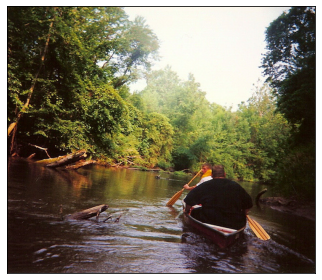

['Three people and a sled .', 'A man in a uniform playing with a black dog .', 'Men playing soccer in a field', 'A man wearing glasses and his black and white dog wearing a black collar are playing with a tennis ball .', 'A soccer player tries to kick the ball in the goal .', 'Man in brown jacket leading black horse']


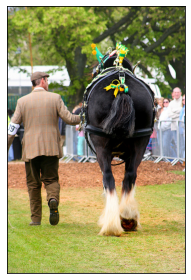

['A man and woman look back at the camera while standing in front of a red art structure .', 'Two men and a woman smile at the camera .', 'Many white puppies are eating food near several brown roosters .', 'A man with sunglasses and a woman with a hat are in front of a car .', 'A red car parked next to a cow in a field .']


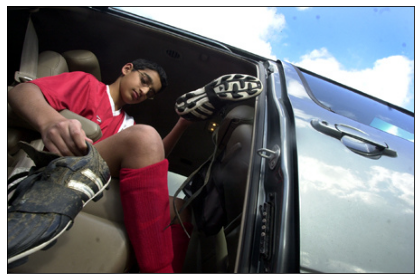

['Two brown dogs playfully fight in the snow .', 'Two black dogs run through sand .', 'A black dog is coming out of the ocean water on the beach with something in its mouth .', 'Two motocross riders next to each other on a dirt track .', 'A black dog standing in shallow water with a pink ball in its mouth .', 'A black dog running in a backyard']


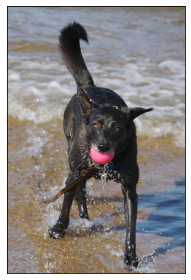

['A dog is running along the beach beside the ocean .', 'A black dog is coming out of the ocean water on the beach with something in its mouth .', 'A man windsurfs in the ocean .', 'Two furry beige dogs playing in ocean surf .']


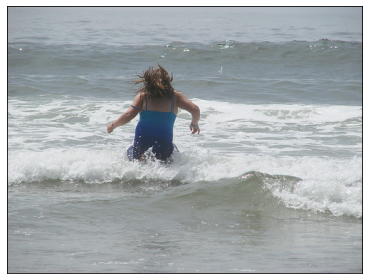


 Посмотрим на тестовые данные 

['A man in a blue shirt lifts up his tennis racket and smiles .', 'A man playing tennis looks very happy .', 'A tennis player in a blue shirt celebrates his match .', 'A tennis player wearing a blue shirt raises his hands and smiles .', 'The tennis player in the blue shirt is holding his racquet up in the air .']


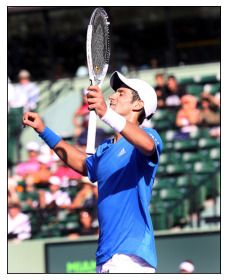

['A bicyclist is jumping on ramp covered with graffiti .', 'A man is jumping his bicycle off of a ramp .', 'A skateboarder jumping on a graffiti covered ramp .', 'Young man on a trick bicycle jumps at the top of a graffiti covered ramp .']


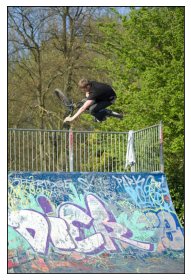

['A brown dog is sitting in some long grass .', 'A brown dog sits still on a hillside .', 'A large tan dog sits on a grassy hill .', 'A large yellow dog is sitting on a hill .', 'The dog is sitting on the side of the hill .']


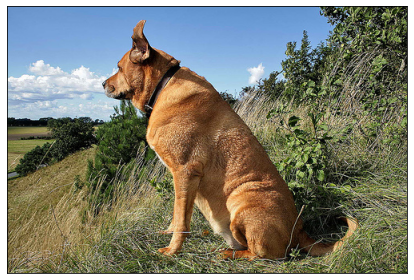

['A group of people perform together onstage .', 'Costumed performers stand onstage with their arms outstretched .', 'Performers performing a play .', 'Three people are doing ballet exercises in extravagant costumes .']


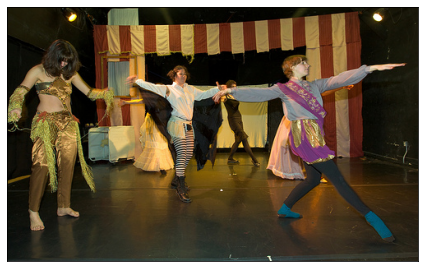

['A black and white dog with a green collar stands in front of a sign .', 'A dog is jumping into a pool for a swim competition', 'A dog jumping off a dock into a pool of water .', 'A dog walks across a puddle of water in Las Vegas .', 'The furry black and white dog is running through a shallow pool .']


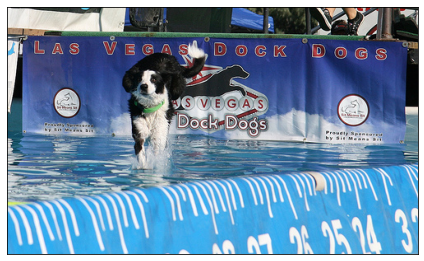

In [16]:
# проверка обучающих данных
print('Посмотрим на обучающие данные', '\n')
img_read(cleared_train_dataset, 'train_images/')

# проверка тестовых данных
print('\n', 'Посмотрим на тестовые данные', '\n')
img_read(cleared_test_queries, 'test_images/')

***Как можем наблюдать, быстрая проверка показала, что из данных не получилось удалить все "нежелательные" фотографии, которые были убраны ранее в пункте 2.2. Вероятно, простого метода отсеивания изображений по ключевым словам не хватает и для решения данной проблемы надо придумать нечто более сложное.***

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

### Функции для векторизации изображений

In [17]:
# Классы и функции необходимые для векторизации изображений

# 1
# Класс выполняющий преобразование изображений
class CustomImageDataset(Dataset):
    
    # инициализация исходных переменных
    def __init__(self, files, file_name, transform=None):
        self.img_labels = files
        self.file_name = file_name
        self.transform = transform

    # метод, осуществляющий преобразования изображений
    def __getitem__(self, idx):
        
        try:
            # для запуска на машине
            img_path = os.path.join(('dataset/' + self.file_name), self.img_labels[idx])
        except:
            # для запуска на сервере
            img_path = os.path.join(('/datasets/image_search/' + self.file_name), self.img_labels[idx])
        
        # чтение изображения
        image = read_image(img_path)
        
        # преобразование изображения
        if self.transform:
            image = self.transform(image)
            
        return image

# 2
# Функция для векторизации изображений, путём вычисления эмбедингов на основе "resnet" модели
def get_vector(image):
    
    # инициализация вектора для эмбедингов
    my_embedding = torch.zeros(512)
    
    # функция для копирования выходных данных слоя
    def copy_data(m, i, o):
        my_embedding.copy_(o.flatten())
    
    # применение вышестоящей функции к выбранному слою
    h = layer.register_forward_hook(copy_data)
    
    # запуск модели для преобразования изображений
    with torch.no_grad():
        resnet_model(image.unsqueeze(0)).float()
        
    # отсоединяем нашу функцию копирования от слоя
    h.remove()
    
    return my_embedding

# 3 
# Функция для получения векторов изображений и объединения их в фрейм данных
def vector_to_frame(datagen, dataset):
    '''
    На вход функции подаются подготовленные преобразованные данные, 
    а также исходный массив с обучающими или тестовыми данными. 
    Для наглядности процесса векторизации добавим в цикл метод "notebook.tqdm".
    '''
    
    # векторизация
    vector = []
    for image in notebook.tqdm(iter(datagen)):
        vector.append(get_vector(image.float()).numpy())
        
    # найдём длину векторизованной строки
    cnt_cols = len(vector[0])
    
    # сформируем список с названиями столбцов
    list_cols = []
    for i in range(cnt_cols):
        list_cols.append('img_' + str(i))

    # на основе полученных векторов сформируем фрейм-данных 
    vectorized_images = pd.DataFrame(np.vstack(vector), columns=list_cols)
    vectorized_images['image'] = (dataset.drop_duplicates('image').reset_index(drop=True)['image'])
    
    return vectorized_images

### Подготовка к векторизации.

In [18]:
# Инициализация модели ResNet18
resnet_model = models.resnet18(weights='DEFAULT')
layer = resnet_model._modules.get('avgpool')

In [19]:
# инициализируем трансформер
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ConvertImageDtype(float), 
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# произведём преобразование обучающих изображений
datagen_train = CustomImageDataset(train_dataset.drop_duplicates('image')['image'].values, 'train_images/', transform)

# произведём преобразование тестовых изображений
datagen_test = CustomImageDataset(test_queries.drop_duplicates('image')['image'].values, 'test_images/', transform)

### Запуск векторизация изображений.

In [20]:
# Проивзедём векторизацию с учётом уже убранных нежелательных изображений на этапе обработки текстов

# векторизация обучающих данных
vectorized_train_images = vector_to_frame(datagen_train, cleared_train_dataset)
display(vectorized_train_images.head())

# векторизация тестовых данных
vectorized_test_images = vector_to_frame(datagen_test, cleared_test_queries)
display(vectorized_test_images.head())

E:\progy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,...,img_503,img_504,img_505,img_506,img_507,img_508,img_509,img_510,img_511,image
0,0.921293,1.029011,0.872155,1.097291,0.962484,0.888029,0.916820,1.205082,0.896389,0.904798,...,0.863430,0.954955,0.882808,1.142998,1.007306,0.937185,0.905982,1.016312,0.964037,1056338697_4f7d7ce270.jpg
1,0.937551,0.957467,0.874600,1.086452,0.952771,0.874099,0.915562,1.138102,0.914627,0.905673,...,0.893725,0.901960,0.843591,1.157936,1.005666,0.955090,0.919949,1.078893,0.964513,3187395715_f2940c2b72.jpg
2,0.969244,1.049863,0.945070,1.088608,0.932957,0.854704,0.947180,1.162139,0.866525,1.009243,...,0.911633,0.874152,0.847019,1.119789,0.978902,0.969058,0.898105,1.054995,0.909908,463978865_c87c6ca84c.jpg
3,0.893938,0.943439,0.887576,1.025347,0.988493,0.905155,0.891352,1.330025,0.933579,0.942815,...,0.855162,0.920946,0.892413,1.115236,1.044147,0.964265,0.903337,1.104622,0.934066,488590040_35a3e96c89.jpg
4,0.905793,1.030638,0.968349,1.032424,0.885392,0.918265,1.002224,1.136032,0.944939,1.016330,...,0.857945,0.937402,0.827410,1.160540,1.013967,1.008168,0.929436,1.072066,0.954073,534875358_6ea30d3091.jpg


E:\progy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


,img_0,img_1,img_2,img_3,img_4,img_5,img_6,img_7,img_8,img_9,...,img_503,img_504,img_505,img_506,img_507,img_508,img_509,img_510,img_511,image
0,0.929016,0.914493,0.955542,1.016975,0.925377,0.834993,0.943237,1.135268,0.980471,0.941937,...,0.861165,0.879532,0.946662,1.106379,1.036797,0.985736,0.921857,1.060052,0.972462,123997871_6a9ca987b1.jpg
1,0.952513,0.999916,0.945458,0.998767,0.935552,0.918432,0.907296,1.159941,0.949708,0.993556,...,0.951810,0.887631,0.886989,1.146305,1.010121,0.979761,0.874646,1.153636,0.936864,1319634306_816f21677f.jpg
2,0.846966,0.929443,0.907637,0.982255,0.958942,0.958709,0.959352,1.165323,0.941204,0.944002,...,0.883422,0.896303,0.857421,1.118590,1.005138,0.967986,0.896453,1.077734,1.012398,1429546659_44cb09cbe2.jpg
3,0.935209,0.952367,0.839891,1.002617,0.898879,0.876131,0.977176,1.149628,0.862808,0.958570,...,0.862618,0.835079,0.918329,1.081599,0.976728,0.926619,0.892114,1.037406,0.930077,1580671272_3e99d94305.jpg
4,0.862157,0.863431,0.899262,1.001895,0.974521,0.871031,0.952972,1.211911,0.996698,1.036358,...,0.853761,0.866606,0.881492,1.058009,0.987354,0.882413,0.954065,1.022101,1.013770,1745110280_0cbff5e273.jpg


***Векторизация изображений произведена с учётом "нежелательных". Данные подготовлены к слиянию.***

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


**// В данный момент не действительно. //**

\**Векторизация текстов была проведена за счёт `TF/IDF` преобразования. Для обработки был применён метод `TfidfVectorizer` в пункте `2.4 Обработка текстов`.**\

**Для векторизации текстов применим предобученную модель `DistilBertModel`. Будем брать признаки из слоя сети.**

### Функции для векторизации текстов

In [21]:
# 1
# Определение размера батча
def func_size_batches(data):
    values = []
    for i in range(1, 1000000):
        if((len(data) / i) % 1 == 0):
            values.append(i)
    return values

# 2
# Токенизация текстов для получения эмбедингов
def tokenizer_func(data, batch_size=1000):

    # подготовка к токенизации
    model_class = transformers.DistilBertModel   
    tokenizer_class = transformers.DistilBertTokenizer
    pretrained_weights = 'distilbert-base-uncased'

    # Загрузка предобученной модели/токенизатора 
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)

    # токенизируем данные
    tokenized = data.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # найдём длину самого большого токена
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    # приведём все токены к одной длине
    padded = [i + [0]*(max_len - len(i)) for i in tokenized.values]

    # сократим токены, которые превышают длину 512, так как модель не может обрабатывать столь длинные токены
    #padded = np.array([token_clipping(i, 512) for i in padded])

    # создание входного вектора из матрицы токенов и передача его в предобученную модель DistilBERT
    input_ids = torch.tensor(padded)

    # создадим маску для важных токенов
    attention_mask = np.where(input_ids != 0, 1, 0)

    # из-за существенной нехватки памяти проделаем все батчами
    embeddings = []
    for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
        batch = torch.LongTensor(input_ids[batch_size * i:batch_size * (i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size * (i + 1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

    # преобразуем в единый массив
    features = []
    for emb in embeddings:
        features.extend(emb)

    '''    
    # отменяем вычислиение градиента
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)

    # получим признаки из скрытых слоёв сети ввиде эмбедингов
    features = last_hidden_states[0][:,0,:].numpy()
    '''

    return features

# 2
# Формирование фрейма из массива векторизованных текстов
def to_frame(vectorize_txt, list_query_id):
    
    # найдём длину векторизованной строки
    cnt_cols = len(vectorize_txt[0][:])
    
    # сформируем список с названиями столбцов
    list_cols = []
    for i in range(cnt_cols):
        list_cols.append('txt_' + str(i))
        
    # соберём всё ввиде фрейма
    df_vectorize_txt = pd.DataFrame(data=vectorize_txt, columns=list_cols)
    # добавим названия описаний
    df_vectorize_txt['query_id'] = list_query_id
    
    return df_vectorize_txt

### Запуск векторизации текстов

In [22]:
# Выберем размеры батчей
# обучающие данные
list_train_batches = func_size_batches(cleared_train_dataset)
print(list_train_batches)

# тестовые данные
list_test_batches = func_size_batches(cleared_test_queries)
print(list_test_batches)

[1, 2, 5, 10, 431, 862, 2155, 4310]
[1, 2, 4, 8, 43, 86, 172, 344]


In [23]:
# вычислим эмбединги для обучающих данных
print('Обучающие данные')
vectorized_train_text = tokenizer_func(cleared_train_dataset['query_text'], list_train_batches[4])
vectorized_train_text = to_frame(vectorized_train_text, cleared_train_dataset['query_id'].values)
display(vectorized_train_text.head(3))
print()

# вычислим эмбединги для тестовых данных
print('Тестовые данные')
vectorized_test_text = tokenizer_func(cleared_test_queries['query_text'], list_test_batches[4])
vectorized_test_text = to_frame(vectorized_test_text, cleared_test_queries['query_id'].values)
display(vectorized_test_text.head(3))

Обучающие данные


,txt_0,txt_1,txt_2,txt_3,txt_4,txt_5,txt_6,txt_7,txt_8,txt_9,...,txt_759,txt_760,txt_761,txt_762,txt_763,txt_764,txt_765,txt_766,txt_767,query_id
0,0.042615,-0.240774,-0.181095,-0.147856,0.165561,-0.072404,0.222482,0.787706,-0.226083,-0.439325,...,-0.156373,0.08246,-0.097126,0.116486,0.218627,-0.107883,-0.213647,0.429329,0.208728,3181701312_70a379ab6e.jpg#2
1,0.042615,-0.240774,-0.181095,-0.147856,0.165561,-0.072404,0.222482,0.787706,-0.226083,-0.439325,...,-0.156373,0.08246,-0.097126,0.116486,0.218627,-0.107883,-0.213647,0.429329,0.208728,3181701312_70a379ab6e.jpg#2
2,0.042615,-0.240774,-0.181095,-0.147856,0.165561,-0.072404,0.222482,0.787706,-0.226083,-0.439325,...,-0.156373,0.08246,-0.097126,0.116486,0.218627,-0.107883,-0.213647,0.429329,0.208728,3181701312_70a379ab6e.jpg#2



Тестовые данные


,txt_0,txt_1,txt_2,txt_3,txt_4,txt_5,txt_6,txt_7,txt_8,txt_9,...,txt_759,txt_760,txt_761,txt_762,txt_763,txt_764,txt_765,txt_766,txt_767,query_id
0,-0.161456,-0.323789,-0.557382,-0.093589,-0.186374,-0.182389,0.419010,0.761608,-0.384778,-0.441233,...,-0.248450,0.203137,-0.153277,0.110182,-0.371278,-0.067148,-0.241913,0.410662,0.179608,123997871_6a9ca987b1.jpg#0
1,-0.112123,-0.336629,-0.290761,-0.167090,-0.058755,-0.364429,0.445345,0.541824,-0.443433,-0.135164,...,-0.257583,0.032897,-0.154706,0.116912,-0.096991,-0.120996,-0.041889,0.238620,0.350801,123997871_6a9ca987b1.jpg#1
2,-0.298937,-0.383324,-0.102646,-0.058727,-0.067439,-0.236826,0.267548,0.513283,-0.342576,-0.375740,...,-0.255180,0.222934,-0.019299,-0.035578,0.056845,-0.098611,0.025505,0.389231,0.305359,123997871_6a9ca987b1.jpg#3


***Путём вычисления эмбедингов для каждого описания получены их векторные представления. Теперь можно объединить оценки с векторизованными изображениями и описаниями.***

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [24]:
# объединим векторизованные фреймы изображений вместе с текстами 

# получение итоговых обучающих данных, с учётом фрейма полученного на основе объединённых оценок
final_train = (result_matching.merge(vectorized_train_images, 'left', on='image').
               merge(vectorized_train_text, 'left', on='query_id').
               dropna().drop_duplicates(subset=['image', 'query_id'], keep='last').
               reset_index(drop=True)
)
display(final_train.head())

# получение итоговых тестовых данных
final_test = (cleared_test_queries.merge(vectorized_test_images, 'left', on='image').
               merge(vectorized_test_text, 'left', on='query_id').
               dropna().drop_duplicates(subset=['image', 'query_id'], keep='last').
               reset_index(drop=True)
)
display(final_test.head())

,image,query_id,estimator_1,estimator_2,estimator_3,final_expert_grade,frac_matching,cnt_matching,cnt_not_matching,final_crowd_grade,...,txt_758,txt_759,txt_760,txt_761,txt_762,txt_763,txt_764,txt_765,txt_766,txt_767
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,-0.049241,-0.156373,0.082460,-0.097126,0.116486,0.218627,-0.107883,-0.213647,0.429329,0.208728
1,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1.0,2.0,2.0,0.5,0.0,0.0,0.0,0.0,...,-0.101414,-0.083590,0.138590,0.067901,0.183706,0.040504,-0.009348,-0.021518,0.230868,0.212783
2,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.148746,-0.282071,0.067357,-0.011632,0.181188,-0.398581,-0.238885,-0.154388,0.421740,0.129614
3,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.030514,-0.348585,0.300627,-0.013796,0.162392,0.053031,-0.146348,-0.062387,0.356317,0.274619
4,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1.0,1.0,2.0,0.0,0.0,0.0,3.0,0.0,...,-0.067764,-0.302424,0.045300,-0.025421,-0.088079,0.231199,-0.019767,-0.214886,0.408941,0.015632


,image,query_id,query_text,img_0,img_1,img_2,img_3,img_4,img_5,img_6,...,txt_758,txt_759,txt_760,txt_761,txt_762,txt_763,txt_764,txt_765,txt_766,txt_767
0,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#0,Girls wearing sports uniforms and eye protection .,0.929016,0.914493,0.955542,1.016975,0.925377,0.834993,0.943237,...,-0.193347,-0.248450,0.203137,-0.153277,0.110182,-0.371278,-0.067148,-0.241913,0.410662,0.179608
1,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#1,Several female lacrosse players are going after a ball .,0.929016,0.914493,0.955542,1.016975,0.925377,0.834993,0.943237,...,-0.293044,-0.257583,0.032897,-0.154706,0.116912,-0.096991,-0.120996,-0.041889,0.238620,0.350801
2,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#3,The woman lacrosse player in blue is about to catch the ball .,0.929016,0.914493,0.955542,1.016975,0.925377,0.834993,0.943237,...,-0.268602,-0.255180,0.222934,-0.019299,-0.035578,0.056845,-0.098611,0.025505,0.389231,0.305359
3,123997871_6a9ca987b1.jpg,123997871_6a9ca987b1.jpg#4,Women play lacrosse .,0.929016,0.914493,0.955542,1.016975,0.925377,0.834993,0.943237,...,-0.205622,-0.357020,0.045606,-0.283028,0.022287,-0.052973,0.040602,0.188562,0.487115,0.337954
4,1319634306_816f21677f.jpg,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,0.952513,0.999916,0.945458,0.998767,0.935552,0.918432,0.907296,...,-0.118000,-0.085152,-0.010665,0.108269,0.002992,0.054194,-0.177101,-0.176532,0.423713,0.213738


***По результатам векторизации текстов и изображений были получены фреймы (обучающие и тестовые данные), на основе которых теперь уже можно обучать модели и разработать систему анализа соответствия описания изображению.*** 

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### Подготовка данных к обучению моделей

In [25]:
# 1
# Класс для хранения модели и значений метрик
class Model_and_Params():
    
    # Инициализируем переменные
    def __init__(self, model=None, train_score=0):
        
        self.model = model
        self.train_score = train_score        
        
    # Обновление значений атрибутов
    def update_attributes(self, model, train_score):
        
        self.model = model
        self.train_score = train_score

# 2
# Функция позволяющая получить имя переменной ввиде строки
def get_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# 3
# Функция позволяющая из списка классов моделей получить перечень названий моделей и список значений метрик
def model_to_string_and_output_values(list_models):
    
    list_string_models = [] # список названий моделей
    list_score_values = [] # список значений метрик
    
    for class_model in list_models:
        list_string_models.append(get_name(class_model.model))
        list_score_values.append(class_model.train_score)
        
    return list_string_models, list_score_values

# 4
# Функция для сортировки массива классов моделей
def sorted_models_on_score_values(list_model, score_values):
    
    sorted_list_models = [] # объявим массив хранящий сортированные модели
    score_values = pd.Series(score_values).sort_values(ascending=False).values # сортируем значения метрик
    for value in score_values:
        for class_model in list_models:
            if(value == class_model.train_score):
                sorted_list_models.append(class_model)
    return sorted_list_models

**Старый вариант..**

**--------------------------------------------------------------------------**

**--------------------------------------------------------------------------**

In [26]:
# объявим массив, в который будем помещать лучшие полученные модели
list_models = []

In [27]:
# выделим признаки и целевые значения
features_train = final_train.drop(columns=final_train.columns[:11])
target_train = final_train['final_grade']

***Последняя подготовка данных завершена, можно приступить к обучению.***

### Модель `Логистическая регрессия`

In [28]:
%%time

# произведём обучение модели

# создаём экземпляр класса со значениями по умолчанию
class_logistic = Model_and_Params()

# зададим параметры парамтеры, которые будем искать
C = np.array(range(1, 20, 1))

grid_space_logistic = {
    'C': C,
    'random_state': [RANDOM_STATE]
}

# обучим модель
Logistic_model = LogisticRegression()

# запустим поиск по сетке
grid = RandomizedSearchCV(Logistic_model, param_distributions=grid_space_logistic, n_jobs=4, n_iter=10, cv=3, 
                                        scoring=metric, random_state=RANDOM_STATE, refit=True)

# найдём лучшую модель для текущих данных
print('Начался поиск лучшей модели:', '[#####:___%%:#####]')
logistic_grid = grid.fit(features_train, target_train)
    
# объявим модель
Logistic_Reg_model = logistic_grid.best_estimator_

# получим значение метрики на кросс-валидации
cross_val_score = logistic_grid.best_score_

# выделим полученные значения в отдельный объект
class_logistic.update_attributes(Logistic_Reg_model, cross_val_score)

print('[---------------------------]','\n', "Метрика {} на кросс-валидации обучающей выборки:".
                                                  format(metric), class_logistic.train_score)

# поместим значение лучшей полученной модели в массив
list_models.append(class_logistic)

Начался поиск лучшей модели: [#####:___%%:#####]
[---------------------------] 
 Метрика accuracy на кросс-валидации обучающей выборки: 0.9291336483268706
Wall time: 1min 4s


E:\progy\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Модель `Случайный лес`

In [29]:
# Зададим возможные параметры модели
depth = np.array(range(1, 21, 1))
est = np.array(range(1, 202, 5))
leafs = np.array(range(1, 6, 1))
splits = np.array(range(2, 7, 1))
bootstrap = [True, False]
criterion = ['gini', 'entropy']
random_state = [RANDOM_STATE]

# объединим все в один словарь
grid_space_forest ={'max_depth':depth,
              'n_estimators':est,              
              'min_samples_leaf':leafs,
              'min_samples_split':splits,
              'bootstrap': bootstrap,
              'criterion': criterion,
              'random_state': random_state
           }

In [30]:
%%time

# произведём обучение модели

# создаём экземпляр класса со значениями по умолчанию
class_forest = Model_and_Params()

# cоздадим экземпляр модели 
r_f_model = RandomForestClassifier()

# запустим поиск по сетке
grid = RandomizedSearchCV(r_f_model, param_distributions=grid_space_forest, n_jobs=4, n_iter=10, cv=3, 
                                        scoring=metric, random_state=RANDOM_STATE, refit=True)
# найдём лучшую модель для текущих данных
print('Начался поиск лучшей модели:', '[#####:___%%:#####]')
forest_grid = grid.fit(features_train, target_train)
    
# объявим модель
RandomForest_model = forest_grid.best_estimator_

# получим значение метрики на кросс-валидации
cross_val_score = forest_grid.best_score_

# выделим полученные значения в отдельный объект
class_forest.update_attributes(RandomForest_model, cross_val_score)

print('[---------------------------]','\n', "Метрика {} на кросс-валидации обучающей выборки:"
                                                  .format(metric), class_forest.train_score)
print('Модель', class_forest.model)

# поместим значение лучшей полученной модели в массив
list_models.append(class_forest)

Начался поиск лучшей модели: [#####:___%%:#####]
[---------------------------] 
 Метрика accuracy на кросс-валидации обучающей выборки: 0.9300726314806497
Модель RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=3, n_estimators=151,
                       random_state=12345)
Wall time: 6min 49s


### Модель "Градиентный бустинг на деревьях решений" `CatBoost`

In [31]:
# определение будет ли использоваться кросс-валидация для поиска лучших параметров модели
# обучим модель на лучших параметрах
if(metric == 'f1'):
    catboost_params = {
              'eval_metric': 'F1',
              'loss_function': 'Logloss',
              'od_type': 'Iter',
              'random_seed': RANDOM_STATE,
              'verbose':100}
else:
    catboost_params = {
              'eval_metric': 'Accuracy',
              'loss_function': 'Logloss',
              'od_type': 'Iter',
              'random_seed': RANDOM_STATE,
              'verbose':100}

grid_space_CatBoost = {
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [32]:
# создаём экземпляр класса со значениями по умолчанию
class_CatBoost = Model_and_Params()

# объявим модель
CatBoost_model = CatBoostClassifier(**catboost_params)

# запустим кроссвалидацию
print('Начался поиск лучших параметров модели:', '[#####:___%%:#####]')
random_cv_result = CatBoost_model.randomized_search(grid_space_CatBoost, 
                                                  X=features_train, y=target_train,
                                                  cv=3,
                                                  n_iter = 5,
                                                  partition_random_seed=RANDOM_STATE,
                                                  refit=True,
                                                  shuffle=True)
# обучим модель на лучших параметрах
print('Далее: обучение на лучших параметрах:', '[#####:___%%:#####]')
CatBoost_model = CatBoostClassifier(**random_cv_result['params'])
CatBoost_model.fit(X=features_train, y=target_train)

# получим значение метрики на кросс-валидации
if(metric == 'f1'):
    cross_val_score = np.median(random_cv_result['cv_results']['test-F1-mean'])
else:
    cross_val_score = np.median(random_cv_result['cv_results']['test-Accuracy-mean'])

# выделим полученные значения в отдельный объект
class_CatBoost.update_attributes(CatBoost_model, cross_val_score)

print('[---------------------------]','\n', "{} обучающей выборки:".format(metric), class_CatBoost.train_score)
print('Модель', class_CatBoost.model)

# поместим значение лучшей полученной модели в массив
list_models.append(class_CatBoost)

Начался поиск лучших параметров модели: [#####:___%%:#####]
0:	learn: 0.9305071	test: 0.9268158	best: 0.9268158 (0)	total: 187ms	remaining: 3m 6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9268157967
bestIteration = 0

0:	loss: 0.9268158	best: 0.9268158 (0)	total: 1.3s	remaining: 5.21s
0:	learn: 0.9305071	test: 0.9268158	best: 0.9268158 (0)	total: 37.6ms	remaining: 37.6s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9268157967
bestIteration = 0

1:	loss: 0.9268158	best: 0.9268158 (0)	total: 2.06s	remaining: 3.09s
0:	learn: 0.9305071	test: 0.9268158	best: 0.9268158 (0)	total: 37.8ms	remaining: 37.7s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9268157967
bestIteration = 0

2:	loss: 0.9268158	best: 0.9268158 (0)	total: 2.81s	remaining: 1.87s
0:	learn: 0.9305071	test: 0.9268158	best: 0.9268158 (0)	total: 84ms	remaining: 1m 23s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9268157967
bestIteration =

127:	learn: 0.2687060	total: 4.84s	remaining: 33s
128:	learn: 0.2681464	total: 4.88s	remaining: 33s
129:	learn: 0.2676920	total: 4.92s	remaining: 32.9s
130:	learn: 0.2672052	total: 4.95s	remaining: 32.9s
131:	learn: 0.2667222	total: 4.99s	remaining: 32.8s
132:	learn: 0.2662804	total: 5.03s	remaining: 32.8s
133:	learn: 0.2658660	total: 5.06s	remaining: 32.7s
134:	learn: 0.2654724	total: 5.1s	remaining: 32.7s
135:	learn: 0.2649860	total: 5.14s	remaining: 32.7s
136:	learn: 0.2645564	total: 5.18s	remaining: 32.6s
137:	learn: 0.2641230	total: 5.22s	remaining: 32.6s
138:	learn: 0.2636821	total: 5.25s	remaining: 32.6s
139:	learn: 0.2632447	total: 5.29s	remaining: 32.5s
140:	learn: 0.2628596	total: 5.33s	remaining: 32.5s
141:	learn: 0.2624564	total: 5.37s	remaining: 32.5s
142:	learn: 0.2620970	total: 5.41s	remaining: 32.4s
143:	learn: 0.2616842	total: 5.45s	remaining: 32.4s
144:	learn: 0.2613150	total: 5.49s	remaining: 32.4s
145:	learn: 0.2609614	total: 5.52s	remaining: 32.3s
146:	learn: 0.260

290:	learn: 0.2405724	total: 10.9s	remaining: 26.6s
291:	learn: 0.2405387	total: 11s	remaining: 26.6s
292:	learn: 0.2404799	total: 11s	remaining: 26.6s
293:	learn: 0.2404299	total: 11s	remaining: 26.5s
294:	learn: 0.2403867	total: 11.1s	remaining: 26.5s
295:	learn: 0.2403462	total: 11.1s	remaining: 26.4s
296:	learn: 0.2402877	total: 11.1s	remaining: 26.4s
297:	learn: 0.2402413	total: 11.2s	remaining: 26.3s
298:	learn: 0.2401907	total: 11.2s	remaining: 26.3s
299:	learn: 0.2401334	total: 11.3s	remaining: 26.3s
300:	learn: 0.2400909	total: 11.3s	remaining: 26.2s
301:	learn: 0.2400363	total: 11.3s	remaining: 26.2s
302:	learn: 0.2399866	total: 11.4s	remaining: 26.1s
303:	learn: 0.2399352	total: 11.4s	remaining: 26.1s
304:	learn: 0.2398905	total: 11.4s	remaining: 26.1s
305:	learn: 0.2398377	total: 11.5s	remaining: 26s
306:	learn: 0.2397908	total: 11.5s	remaining: 26s
307:	learn: 0.2397430	total: 11.6s	remaining: 26s
308:	learn: 0.2396973	total: 11.6s	remaining: 25.9s
309:	learn: 0.2396461	to

454:	learn: 0.2348416	total: 16.9s	remaining: 20.3s
455:	learn: 0.2348222	total: 17s	remaining: 20.2s
456:	learn: 0.2347903	total: 17s	remaining: 20.2s
457:	learn: 0.2347677	total: 17s	remaining: 20.2s
458:	learn: 0.2347516	total: 17.1s	remaining: 20.1s
459:	learn: 0.2347352	total: 17.1s	remaining: 20.1s
460:	learn: 0.2347068	total: 17.1s	remaining: 20s
461:	learn: 0.2346795	total: 17.2s	remaining: 20s
462:	learn: 0.2346588	total: 17.2s	remaining: 20s
463:	learn: 0.2346408	total: 17.3s	remaining: 19.9s
464:	learn: 0.2346129	total: 17.3s	remaining: 19.9s
465:	learn: 0.2345837	total: 17.3s	remaining: 19.9s
466:	learn: 0.2345535	total: 17.4s	remaining: 19.8s
467:	learn: 0.2345301	total: 17.4s	remaining: 19.8s
468:	learn: 0.2345015	total: 17.4s	remaining: 19.7s
469:	learn: 0.2344714	total: 17.5s	remaining: 19.7s
470:	learn: 0.2344338	total: 17.5s	remaining: 19.7s
471:	learn: 0.2343967	total: 17.5s	remaining: 19.6s
472:	learn: 0.2343784	total: 17.6s	remaining: 19.6s
473:	learn: 0.2343578	to

615:	learn: 0.2312323	total: 22.8s	remaining: 14.2s
616:	learn: 0.2312119	total: 22.8s	remaining: 14.2s
617:	learn: 0.2311918	total: 22.9s	remaining: 14.1s
618:	learn: 0.2311729	total: 22.9s	remaining: 14.1s
619:	learn: 0.2311541	total: 23s	remaining: 14.1s
620:	learn: 0.2311405	total: 23s	remaining: 14s
621:	learn: 0.2311181	total: 23s	remaining: 14s
622:	learn: 0.2310981	total: 23.1s	remaining: 14s
623:	learn: 0.2310735	total: 23.1s	remaining: 13.9s
624:	learn: 0.2310498	total: 23.1s	remaining: 13.9s
625:	learn: 0.2310193	total: 23.2s	remaining: 13.8s
626:	learn: 0.2309970	total: 23.2s	remaining: 13.8s
627:	learn: 0.2309789	total: 23.2s	remaining: 13.8s
628:	learn: 0.2309542	total: 23.3s	remaining: 13.7s
629:	learn: 0.2309379	total: 23.3s	remaining: 13.7s
630:	learn: 0.2309113	total: 23.3s	remaining: 13.7s
631:	learn: 0.2308837	total: 23.4s	remaining: 13.6s
632:	learn: 0.2308579	total: 23.4s	remaining: 13.6s
633:	learn: 0.2308369	total: 23.4s	remaining: 13.5s
634:	learn: 0.2308228	to

774:	learn: 0.2281243	total: 28.5s	remaining: 8.29s
775:	learn: 0.2281105	total: 28.6s	remaining: 8.25s
776:	learn: 0.2280869	total: 28.6s	remaining: 8.21s
777:	learn: 0.2280695	total: 28.6s	remaining: 8.17s
778:	learn: 0.2280625	total: 28.7s	remaining: 8.13s
779:	learn: 0.2280439	total: 28.7s	remaining: 8.1s
780:	learn: 0.2280200	total: 28.8s	remaining: 8.06s
781:	learn: 0.2279943	total: 28.8s	remaining: 8.03s
782:	learn: 0.2279680	total: 28.8s	remaining: 7.99s
783:	learn: 0.2279491	total: 28.9s	remaining: 7.95s
784:	learn: 0.2279245	total: 28.9s	remaining: 7.92s
785:	learn: 0.2279054	total: 28.9s	remaining: 7.88s
786:	learn: 0.2278890	total: 29s	remaining: 7.84s
787:	learn: 0.2278736	total: 29s	remaining: 7.8s
788:	learn: 0.2278590	total: 29s	remaining: 7.77s
789:	learn: 0.2278422	total: 29.1s	remaining: 7.73s
790:	learn: 0.2278202	total: 29.1s	remaining: 7.69s
791:	learn: 0.2278052	total: 29.2s	remaining: 7.66s
792:	learn: 0.2277849	total: 29.2s	remaining: 7.62s
793:	learn: 0.227766

936:	learn: 0.2251912	total: 34.3s	remaining: 2.31s
937:	learn: 0.2251711	total: 34.3s	remaining: 2.27s
938:	learn: 0.2251528	total: 34.4s	remaining: 2.23s
939:	learn: 0.2251295	total: 34.4s	remaining: 2.2s
940:	learn: 0.2251114	total: 34.4s	remaining: 2.16s
941:	learn: 0.2250958	total: 34.5s	remaining: 2.12s
942:	learn: 0.2250790	total: 34.5s	remaining: 2.08s
943:	learn: 0.2250597	total: 34.5s	remaining: 2.05s
944:	learn: 0.2250445	total: 34.6s	remaining: 2.01s
945:	learn: 0.2250286	total: 34.6s	remaining: 1.98s
946:	learn: 0.2250134	total: 34.6s	remaining: 1.94s
947:	learn: 0.2249930	total: 34.7s	remaining: 1.9s
948:	learn: 0.2249739	total: 34.7s	remaining: 1.86s
949:	learn: 0.2249534	total: 34.7s	remaining: 1.83s
950:	learn: 0.2249293	total: 34.8s	remaining: 1.79s
951:	learn: 0.2249145	total: 34.8s	remaining: 1.75s
952:	learn: 0.2249000	total: 34.9s	remaining: 1.72s
953:	learn: 0.2248773	total: 34.9s	remaining: 1.68s
954:	learn: 0.2248614	total: 34.9s	remaining: 1.65s
955:	learn: 0.

### Модель "градиентного бустинга"  `LightGBM`

In [33]:
# Зададим возможные параметры модели
depth = np.array(range(2, 20, 2))
est = np.array(range(50, 550, 50))
num_leaves = np.array([2 * x for x in depth])
lr = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
boosting_type = ['gbdt', 'dart', 'goss']
random_state = [RANDOM_STATE]

# объединим все в один словарь
grid_space_lgbm = {'max_depth': depth,
                  'n_estimators': est,
                  'num_leaves': num_leaves,
                  'learning_rate': lr,
                  'boosting_type': boosting_type,
                  'force_col_wise': [True, True],
                  'random_state': random_state
           }

In [34]:
%%time

# произведём обучение модели

# создаём экземпляр класса со значениями по умолчанию
class_lightGBM = Model_and_Params()

# cоздадим экземпляр модели 
LightGBM_model = LGBMClassifier()

# запустим поиск по сетке
grid = RandomizedSearchCV(LightGBM_model, param_distributions=grid_space_lgbm, n_jobs=4, n_iter=10, cv=3, 
                                        scoring=metric, random_state=RANDOM_STATE, refit=True)
# найдём лучшую модель для текущих данных
print('Начался поиск лучшей модели:', '[#####:___%%:#####]')
LightGBM_grid = grid.fit(features_train, target_train)
   
# объявим модель
LightGBM_model = LightGBM_grid.best_estimator_

# получим значение метрики на кросс-валидации
cross_val_score = LightGBM_grid.best_score_

# выделим полученные значения в отдельный объект
class_lightGBM.update_attributes(LightGBM_model, cross_val_score)

print('[---------------------------]','\n', "Метрика {} на кросс-валидации обучающей выборки:".
                                                format(metric), class_lightGBM.train_score)
print('Модель', class_lightGBM.model)

# поместим значение лучшей полученной модели в массив
list_models.append(class_lightGBM)

Начался поиск лучшей модели: [#####:___%%:#####]
[LightGBM] [Info] Number of positive: 2543, number of negative: 33666
[LightGBM] [Info] Total Bins 324794
[LightGBM] [Info] Number of data points in the train set: 36209, number of used features: 1280
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070231 -> initscore=-2.583144
[LightGBM] [Info] Start training from score -2.583144
[---------------------------] 
 Метрика accuracy на кросс-валидации обучающей выборки: 0.9297688434189593
Модель LGBMClassifier(force_col_wise=True, learning_rate=0.001, max_depth=14,
               num_leaves=36, random_state=12345)
Wall time: 2min 52s


### Проверка на "адекватность"

In [35]:
# создадим модель, в которой будем предсказывать соответствие случайным образом
class random_values():

    # Инициализируем переменные
    def __init__(self, target, random_state=0):
        
        self.target = target
        self.random_state = random_state
        
    # метод для генерации значений
    def generic_target(self):

        # зафиксируем "случайность"
        random.seed(self.random_state)

        # подготовим данные для генерации
        length = len(self.target)
        zeros = np.zeros(int(length / 2))
        ones = np.ones(int(length / 2))
        new = np.concatenate((ones, zeros), axis= None)

        # перемешаем полученный список
        random.shuffle(new)

        # проверка соответствия длины
        if (len(new) == length):
            return new
        elif (len(new) > length):
            return new[:1]
        else:
            return np.append(new, random.choice([0, 1])) 

In [36]:
# создаём экземпляр класса со значениями по умолчанию
class_Random_target = Model_and_Params()

# получим случайные значения
random_target = random_values(target_train, random_state=RANDOM_STATE)
random_target = random_target.generic_target()

# вычислим метрику
if(metric == 'f1'):
    random_score = f1_score(target_train, random_target)
else:
    random_score = accuracy_score(target_train, random_target)

# выделим полученные значения в отдельный объект
if(metric == 'f1'):
    class_Random_target.update_attributes(random_target, random_score)
else:
    class_Random_target.update_attributes(random_target, random_score)

print("Метрика {} на кросс-валидации обучающей выборки:".format(metric), class_Random_target.train_score)
print('Модель', get_name(class_Random_target.model))

# поместим значение лучшей полученной модели в массив
list_models.append(class_Random_target)

Метрика accuracy на кросс-валидации обучающей выборки: 0.49843961446049323
Модель random_target


### Определение лучшей модели

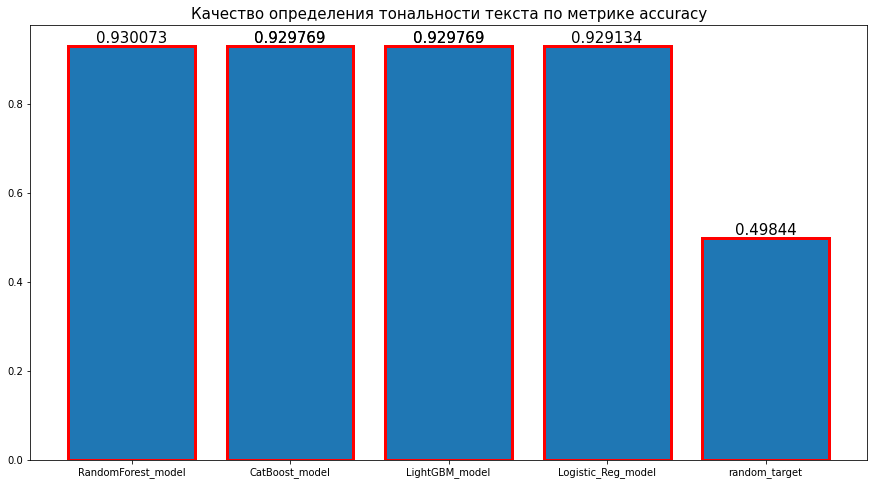

In [37]:
# получим значения метрик для сортировки
_, values = model_to_string_and_output_values(list_models)

# произведём сортировку моделей по качеству прогноза на валидации
list_models = sorted_models_on_score_values(list_models, values)

# получим уже сортированные данные
elements, values = model_to_string_and_output_values(list_models)

# построим диаграмму по точности прогноза моделей
fig, ax = plt.subplots(figsize=(15, 8))

plt.rc('font', size=15) # увеличим размер шрифтов

rects = ax.bar(elements, values, edgecolor='red', linewidth=3)
ax.bar_label(rects)
# зададим подписи: название диаграммы и название оси
ax.set_title('Качество определения тональности текста по метрике {}'.format(metric), fontsize=15)
plt.show()

***По результатам кроссвалидации лучшей моделью стала - `Случайный лес`. Все модели прошли проверку на адекватность, приступим к тестированию.***

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [38]:
# подготовим тестовые данные
features_test = final_test.drop(columns=final_test.columns[:3])

In [39]:
# определим похожесть описаний изображениям для тестовых данных
predict_test = list_models[0].model.predict(features_test)

# добавим результат предсказаний в фрейм с тестовыми данными
final_test['predict_model'] = predict_test

**Визуально оценим работу полученной модели.**


 Посмотрим на тестовые данные 

['Two black dogs are playing tug-of-war with an orange toy .']


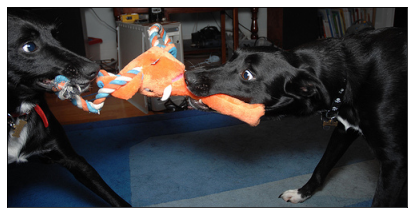

['A white dog with a stick in his mouth standing next to a black dog .']


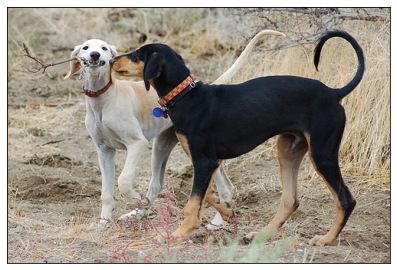

['many people walk through the store .']


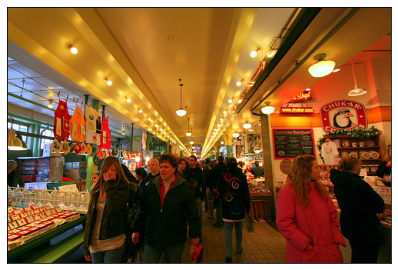

['A brown dog and a black and white dog stand beside a hole in the dirt .', 'Two dogs are shaking water off .']


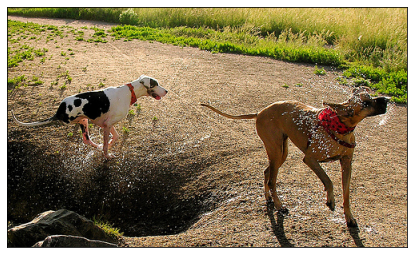

['A tan dog runs through the brush .']


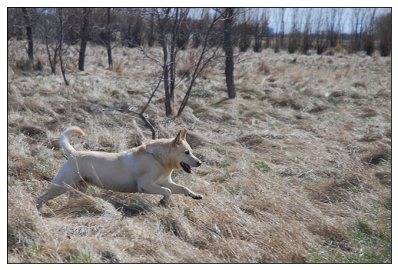

In [40]:
# получим 10 случайных тестовых изображений, в которых модель определила похожесть с описанием

# добавлено, чтобы не падал код
if (final_test['predict_model'].sum() > 0):
    test_df = final_test[final_test['predict_model'] == 1].sample(n=10, random_state=RANDOM_STATE)
else:
    test_df = final_test.sample(n=10, random_state=RANDOM_STATE)

# проверка тестовых данных
print('\n', 'Посмотрим на тестовые данные', '\n')
img_read(test_df, 'test_images/')

## Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска